Import Libraries

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve


Load Dataset

In [210]:
df = pd.read_csv('generated_dataset.csv')
df.head()


,Wellhead Temp. (C),Wellhead Press (psi),MMCFD- gas,BOPD (barrel of oil produced per day),BWPD (barrel of water produced per day),BSW - basic solid and water (%),CO2 mol. (%) @ 25 C & 1 Atm.,Gas Grav.,CR-corrosion defect
0,53.35,1105.13,12.87,1378.93,2812.62,75.64,3.3628,0.7205,0.2245
1,72.25,1026.31,3.42,1028.75,919.92,44.21,3.8679,0.8940,0.2262
2,65.08,722.96,6.23,2017.92,1212.42,17.55,2.3552,0.7661,0.2305
3,60.71,1557.23,11.71,558.22,1716.09,65.79,1.7253,0.7738,0.2303
4,46.19,1304.42,8.58,1280.47,1929.22,37.45,1.8327,0.7611,0.2202


Binning Target: Leak vs No Leak (Percentile-based)

In [211]:
percentile = 0.8 # Adjust this percentile as needed
threshold = df['CR-corrosion defect'].quantile(percentile)
df['Leak_Status'] = np.where(df['CR-corrosion defect'] > threshold, 'Leak', 'No Leak')





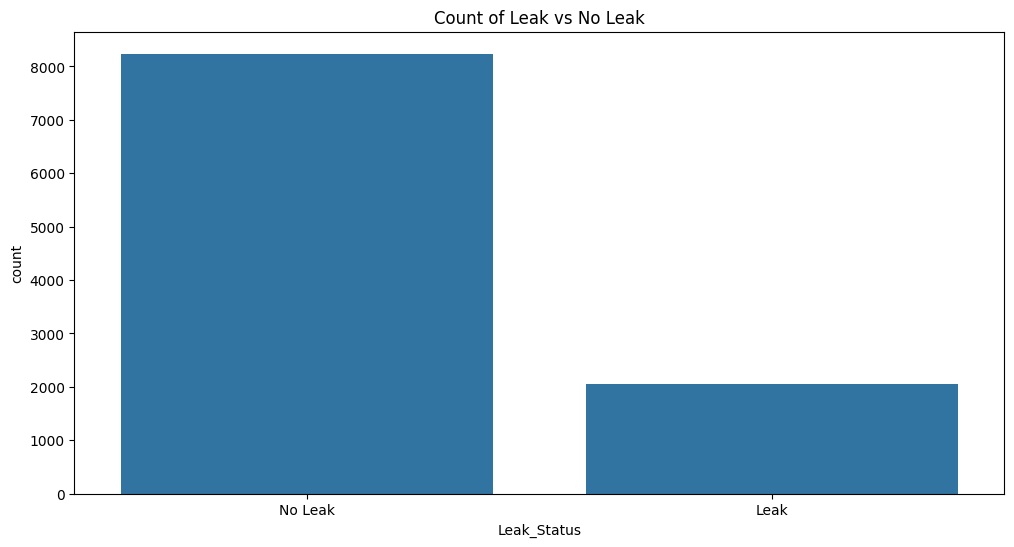

In [212]:
import seaborn as sns

# Visualize the distribution of features by Leak_Status
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Leak_Status')
plt.title('Count of Leak vs No Leak')
plt.show()

Encode Target Labels

In [213]:
le = LabelEncoder()
y = le.fit_transform(df['Leak_Status'])


Train-Test Split

In [214]:
X = df.drop(['CR-corrosion defect', 'Leak_Status'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Train SVM Model

In [215]:
from imblearn.over_sampling import SMOTE

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


model.fit(X_res, y_res)

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Train AUC ROC:", roc_auc_score(y_train, y_train_proba[:, 1]))


Train Accuracy: 0.8379691485485242
Train AUC ROC: 0.9262388971614077


Predict & Evaluate

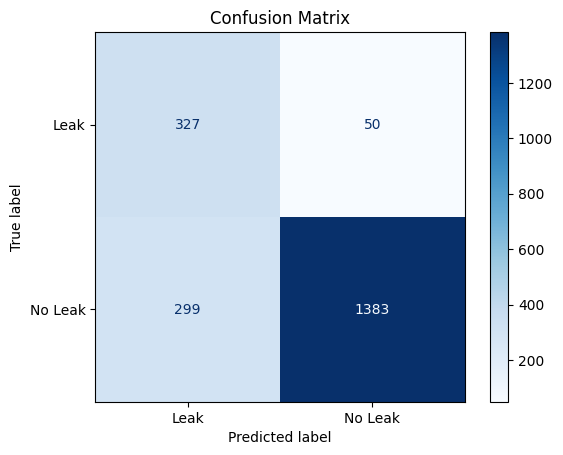

,precision,recall,f1-score,support
Leak,0.861538,0.445623,0.587413,377.000000
No Leak,0.887876,0.983948,0.933446,1682.000000
accuracy,0.885381,0.885381,0.885381,0.885381
macro avg,0.874707,0.714786,0.760429,2059.000000
weighted avg,0.883053,0.885381,0.870088,2059.000000


In [216]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

custom_threshold = 0.3
y_pred_custom = (y_proba >= custom_threshold).astype(int)


ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



report = classification_report(y_test, y_pred_custom, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)


Visualize ROC Curves

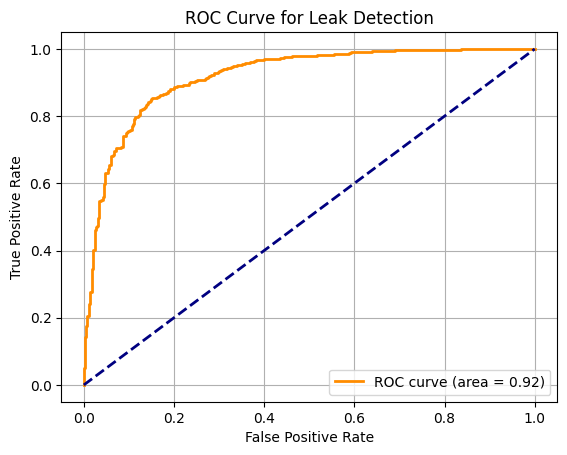

In [217]:
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Leak Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



Visualize Feature Importance

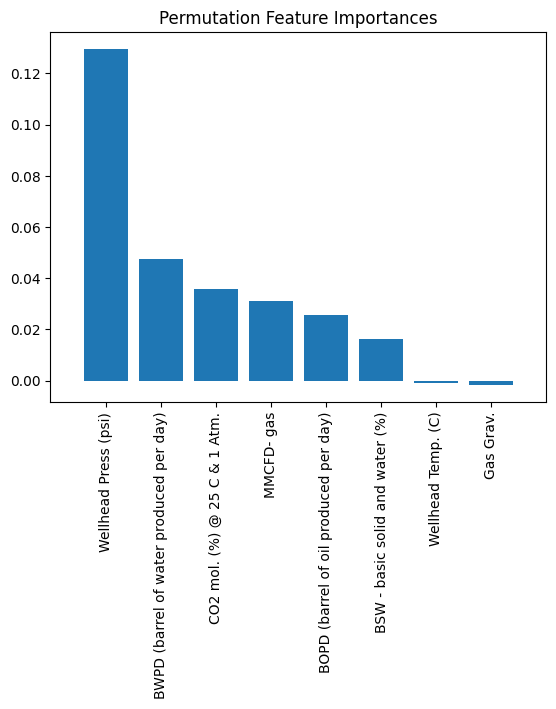

In [218]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

plt.title("Permutation Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Save model

In [219]:
# Save model with pickle
import pickle

with open('rf_leak_detection_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Example usecase

In [220]:
# Load model with pickle
with open('svm_leak_detection_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Example feature values
example = pd.DataFrame([{
    'Wellhead Temp. (C)': 85,
    'Wellhead Press (psi)': 2500,
    'MMCFD- gas': 12,
    'BOPD (barrel of oil produced per day)': 500,
    'BWPD (barrel of water produced per day)': 200,
    'BSW - basic solid and water (%)': 5,
    'CO2 mol. (%) @ 25 C & 1 Atm.': 2.5,
    'Gas Grav.': 0.7
}])

# Use same scaler as during training
example_scaled = scaler.transform(example)

# Predict
pred = model.predict(example_scaled)
pred_label = le.inverse_transform(pred)
print("Predicted Leak Status:", pred_label[0])

# Get probability scores for each class
proba = model.predict_proba(example_scaled)

# Probability for the predicted class:
print(f"Probability: {proba[0][pred[0]] * 100:.2f}%")

Predicted Leak Status: No Leak
Probability: 97.22%
